In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
start = (2000, 1, 1)
start = datetime.datetime(*start) 
# end = datetime.date.today() - datetime.timedelta(1) # 어제 날짜
end = datetime.date.today()

In [3]:
df = pdr.DataReader('005930.KS', 'yahoo', start, end)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-04,6110.0,5660.0,6000.0,6110.0,74195000.0,4761.183105
2000-01-05,6060.0,5520.0,5800.0,5580.0,74680000.0,4348.184082
2000-01-06,5780.0,5580.0,5750.0,5620.0,54390000.0,4379.354004
2000-01-07,5670.0,5360.0,5560.0,5540.0,40305000.0,4317.015625
2000-01-10,5770.0,5580.0,5600.0,5770.0,46880000.0,4496.240723


In [4]:
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-04-23,82900.0,81600.0,81900.0,82800.0,17805080.0,82800.0
2021-04-26,83500.0,82600.0,82900.0,83500.0,15489938.0,83500.0
2021-04-27,83300.0,82500.0,83200.0,82900.0,12941533.0,82900.0
2021-04-28,83200.0,82100.0,83200.0,82100.0,15596759.0,82100.0
2021-04-29,82500.0,81500.0,82400.0,81700.0,19904834.0,81700.0


In [5]:
look_back = 20
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i : (i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i+look_back])
    return np.array(dataX), np.array(dataY)

In [6]:
nparr = df['Close'].values[0:] 
nparr.astype('float32')
print(nparr)

[ 6110.  5580.  5620. ... 82900. 82100. 81700.]


In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
nparr = nparr.reshape(-1, 1)
nptf = scaler.fit_transform(nparr)

In [8]:
len(nptf)

5355

In [9]:
TEST_SIZE = 200 
train = nptf[:-TEST_SIZE]
test = nptf[-TEST_SIZE:]

In [10]:
len(train)

5155

In [11]:
len(test)

200

In [12]:
trainX, trainY = create_dataset(train, look_back)

In [13]:
testX, testY = create_dataset(test, look_back)

In [14]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))

In [15]:
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [16]:
trainX.shape

(5135, 1, 20)

In [17]:
x_train, x_valid, y_train, y_valid = train_test_split(trainX, 
                                                      trainY, 
                                                      test_size=0.2)
print('x_train shape :', x_train.shape)
print('x_valid shape :', x_valid.shape)

x_train shape : (4108, 1, 20)
x_valid shape : (1027, 1, 20)


In [18]:
print('testX shape :', testX.shape)
print('testY shape :', testY.shape)

testX shape : (180, 1, 20)
testY shape : (180, 1)


In [19]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1)) 
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 400       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 405
Trainable params: 405
Non-trainable params: 0
_________________________________________________________________


In [20]:
EPOCHS = 20

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=1,
          validation_data=(x_valid, y_valid),
          verbose=1)

Epoch 1/20
4108/4108 [==============================] - 19s 4ms/step - loss: 5.4080e-04 - val_loss: 1.1332e-04
Epoch 2/20
4108/4108 [==============================] - 11s 3ms/step - loss: 1.3477e-04 - val_loss: 1.0724e-04
Epoch 3/20
4108/4108 [==============================] - 11s 3ms/step - loss: 1.1416e-04 - val_loss: 5.8971e-05
Epoch 4/20
4108/4108 [==============================] - 11s 3ms/step - loss: 8.4254e-05 - val_loss: 1.2796e-04
Epoch 5/20
4108/4108 [==============================] - 11s 3ms/step - loss: 9.0430e-05 - val_loss: 5.5287e-05
Epoch 6/20
4108/4108 [==============================] - 11s 3ms/step - loss: 8.1058e-05 - val_loss: 7.0917e-05
Epoch 7/20
4108/4108 [==============================] - 11s 3ms/step - loss: 7.3121e-05 - val_loss: 7.9925e-05
Epoch 8/20
4108/4108 [==============================] - 11s 3ms/step - loss: 8.8116e-05 - val_loss: 6.3868e-05
Epoch 9/20
4108/4108 [==============================] - 11s 3ms/step - loss: 6.5823e-05 - val_loss: 4.9074e-05
E

In [21]:
# 예측
pred = model.predict(testX)

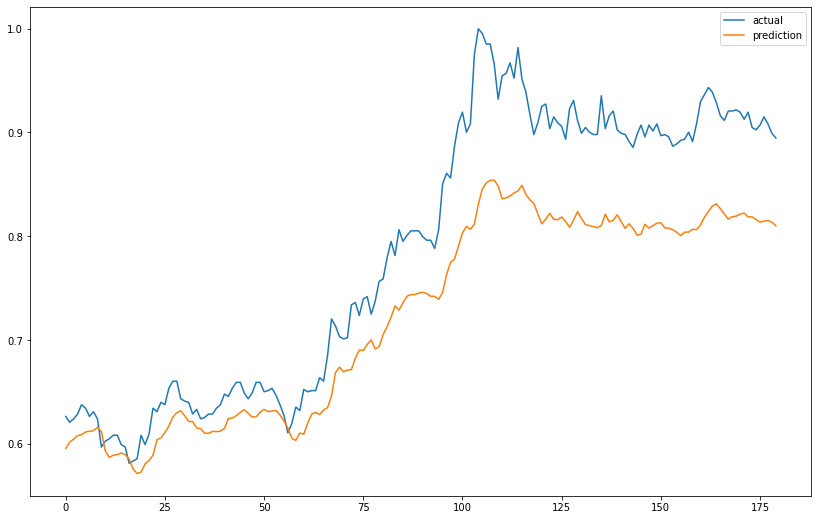

In [22]:
plt.figure(figsize=(14, 9))
plt.plot(testY, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [23]:
lastX = testX[-1]
lastX = np.reshape(lastX, (1, 1, look_back))
lastY = model.predict(lastX)
lastY = scaler.inverse_transform(lastY)
print("오늘 예측 값은 :", lastY)

오늘 예측 값은 : [[74221.164]]


In [24]:
print("오늘 값은")
nparr[-1]

오늘 값은


array([81700.])

In [25]:
lastX = nptf[-look_back:]
lastX = np.reshape(lastX, (1, 1, look_back))
lastY = model.predict(lastX)
lastY = scaler.inverse_transform(lastY)
print("내일 예측 값은 :", lastY)

내일 예측 값은 : [[73982.09]]
